In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import tensorflow as tf

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

2025-04-21 17:44:47.348309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745250287.438873  470860 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745250287.467443  470860 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745250287.779309  470860 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745250287.779366  470860 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745250287.779368  470860 computation_placer.cc:177] computation placer alr

In [2]:
def load_dataset(up_to= None):
    '''
    Charge les fichiers DVF jusqu'à une année donnée (incluse).

    Paramètres:
        up_to (str): Année maximale à charger, ex: "2020", "2023".

    Return:
        DataFrame Pandas combiné sans doublons.
    '''

    data_files = {
        "2019": "data/ValeursFoncieres-2019-S2.txt",
        "2020": "data/ValeursFoncieres-2020.txt",
        "2021": "data/ValeursFoncieres-2021.txt",
        "2022": "data/ValeursFoncieres-2022.txt",
        "2023": "data/ValeursFoncieres-2023.txt",
        "2024": "data/ValeursFoncieres-2024-S1.txt",
    }

    valid_years = list(data_files.keys())
    if (up_to is not None) and (up_to not in valid_years):
        print("Erreur: \"up_to\" doit être une année entre \"2019\" et \"2024\".")
        return -1

    data_list = []
    for year, path in data_files.items():
        print(f"Chargement {year}...")
        df = pd.read_csv(path, delimiter='|', dtype= str)
        data_list.append(df)
        if (up_to is not None) and (year == up_to):
            break

    data = pd.concat(data_list, ignore_index= True)
    # data.drop_duplicates(inplace=True) #? Fait crash le kernel, désactivé pour le moment
    print(f"\n{len(data):,} lignes chargées au total.")

    return data

In [3]:
def parse_dataset(dataset, min_price= 1_000, max_price= 2_000_000):
    '''
    Parsing des données, on ne garde que les lignes des ventes et de certains types de local.
    Seule les colonnes suivantes sont gardées : "Valeur fonciere", "Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales".
    Les lignes comportant des NaN sont supprimées.
    Ajout de colonnes pour "Année", "Mois", "Jour".
    Valeurs de target plafonnée.

    Paramètres:
        dataset (dataset): strucutre d'un fichier DVF.
        max_price (float): valeur maximum de target.

    Retour:
        dataFrames Pandas, X contenant les features et y contenant la target.
    '''

    if max_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price >= max_price:
        print("Erreur: \"min_price\" doit être < à \"max_price\"")
        return -1

    dataset = dataset[(dataset["Nature mutation"] == "Vente")]

    dataset = dataset.dropna(subset= ["Date mutation", "Valeur fonciere", "Code departement", "Type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain", "Code postal"])
    dataset["Valeur fonciere"] = dataset["Valeur fonciere"].str.replace(",", ".", regex= False).astype(float)
    dataset["Date mutation"] = pd.to_datetime(dataset["Date mutation"], format="%d/%m/%Y", errors="coerce")
    # dataset["Annee"] = dataset["Date mutation"].dt.year
    dataset["Mois"] = dataset["Date mutation"].dt.month
    # dataset["Jour"] = dataset["Date mutation"].dt.day
    dataset["Surface reelle bati"] = dataset["Surface reelle bati"].str.replace(",", ".", regex= False).astype(float)
    dataset["Nombre pieces principales"] = dataset["Nombre pieces principales"].astype(int)
    dataset["Surface terrain"] = dataset["Surface terrain"].str.replace(",", ".", regex= False).astype(float)
    dataset["Code postal"] = dataset["Code postal"].astype(str)
    dataset["Prix au m2"] = dataset["Valeur fonciere"] / dataset["Surface reelle bati"]

    freq_cp = dataset["Code postal"].value_counts()
    dataset["Frequence CP"] = dataset["Code postal"].map(freq_cp)
    dataset = dataset[(dataset["Type local"] == "Maison") | (dataset["Type local"] == "Appartement")]
    dataset = dataset[(dataset["Valeur fonciere"] >= min_price) &
                (dataset["Valeur fonciere"] <= max_price) &
                (dataset["Surface reelle bati"] >= 15) &
                (dataset["Surface reelle bati"] <= 300) &
                (dataset["Surface terrain"] <= 10_00) &
                (dataset["Nombre pieces principales"] >= 1) &
                (dataset["Nombre pieces principales"] <= 12)
                # (dataset["Prix au m2"] >= 300) &
                # (dataset["Prix au m2"] <= 10_000)
                ]
    features = ["Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Mois", "Frequence CP"]
    target = "Valeur fonciere"

    return dataset, features, target

In [4]:
def visualize_dataset(data, min_price= 10_000, max_price= 2_000_000):

    # dataset, features, target = parse_dataset(data, min_price= 0, max_price= 100_000_000)
    dataset, features, target = parse_dataset(data, min_price= 10_000, max_price= 2_000_000)
    X = dataset[features]
    print("Shape des features:", X.shape)
    print("Colonnes:", X.columns.tolist())
    print("\nAperçu des données:")
    display(X.head())
    print("\nRésumé statistique des variables numériques:")
    display(X.describe())
    print("\nRépartition des types de biens:")
    print(X["Type local"].value_counts())

    plt.figure(figsize= (20, 6))
    for type_local in dataset["Type local"].unique():
        subset = dataset[dataset["Type local"] == type_local]
        plt.scatter(subset["Date mutation"], subset["Valeur fonciere"], label= type_local, alpha= .2, s= 1)
    plt.title("Ventes à différentes dates")
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.xlabel("Date de vente")
    plt.ylabel("Valeur foncière (€)")
    plt.yscale("log")
    plt.grid(True, which= "both")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= (10, 6))
    for type_local in dataset["Type local"].unique():
       subset = dataset[dataset["Type local"] == type_local]
       plt.hist(subset["Valeur fonciere"], label= type_local, alpha= .5, bins= 200, log= False, density= False)
    plt.hist(dataset["Valeur fonciere"], label= "Total", bins= 200, log= False, density= False, histtype= "step", color = 'k')
    plt.title("Distribution des valeurs foncière")
    plt.xlabel("Valeur foncière (€)")
    plt.ylabel("Nombre de ventes")
    plt.grid(True)
    plt.tight_layout()
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.show()

    plt.figure(figsize= (10, 6))
    for type_local in dataset["Type local"].unique():
        subset = dataset[dataset["Type local"] == type_local]
        plt.scatter(subset["Surface reelle bati"], subset["Valeur fonciere"], label= type_local, alpha= .1, s= 1)
    plt.title("Valeur foncière en fonction de la surface du bâtiement")
    plt.xlabel("Surface réelle (m²)")
    plt.ylabel("Valeur foncière (€)")
    plt.grid(True)
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= (20, 6))
    plt.scatter(dataset["Code departement"], dataset["Prix au m2"], s= 1)
    for departement in dataset["Code departement"].unique():
        subset = dataset[dataset["Code departement"] == departement]
        plt.errorbar(departement, np.mean(subset["Prix au m2"]), yerr= np.std(subset["Prix au m2"], ddof= 1), c= "k", capsize= 6)
    plt.title("Distribution du prix au m² par département")
    plt.xlabel("Code département")
    plt.ylabel("Prix au m² (€)")
    plt.xticks(rotation= 45)
    plt.yscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= (10, 6))
    seaborn.heatmap(dataset.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Matrice de corrélation des variables numériques")
    plt.tight_layout()
    plt.show()

    return

In [5]:
data = load_dataset(up_to= "2021") #TODO crash toujour lorsque load au dessus de 2021

Chargement 2019...
Chargement 2020...
Chargement 2021...

10,162,527 lignes chargées au total.


Shape des features: (1676701, 7)
Colonnes: ['Code departement', 'Type local', 'Surface terrain', 'Surface reelle bati', 'Nombre pieces principales', 'Mois', 'Frequence CP']

Aperçu des données:


Code departement Type local  Surface terrain  Surface reelle bati  \
0               01     Maison            695.0                150.0   
1               01     Maison            888.0                 94.0   
2               01     Maison            500.0                 94.0   
3               01     Maison            522.0                 90.0   
6               01     Maison            557.0                110.0   

   Nombre pieces principales  Mois  Frequence CP  
0                          5     7          1376  
1                          4     7           910  
2                          4     7           910  
3                          3     7           910  
6                          5     7           313


Résumé statistique des variables numériques:


Surface terrain  Surface reelle bati  Nombre pieces principales  \
count     1.676701e+06         1.676701e+06               1.676701e+06   
mean      4.414466e+02         9.427951e+01               3.963596e+00   
std       2.648962e+02         4.160280e+01               1.498827e+00   
min       0.000000e+00         1.500000e+01               1.000000e+00   
25%       2.140000e+02         6.700000e+01               3.000000e+00   
50%       4.330000e+02         9.000000e+01               4.000000e+00   
75%       6.220000e+02         1.160000e+02               5.000000e+00   
max       1.000000e+03         3.000000e+02               1.200000e+01   

               Mois  Frequence CP  
count  1.676701e+06  1.676701e+06  
mean   7.434407e+00  1.007687e+03  
std    3.295396e+00  9.249630e+02  
min    1.000000e+00  1.000000e+00  
25%    5.000000e+00  4.220000e+02  
50%    8.000000e+00  7.380000e+02  
75%    1.000000e+01  1.232000e+03  
max    1.200000e+01  9.054000e+03


Répartition des types de biens:
Type local
Maison         1458159
Appartement     218542
Name: count, dtype: int64


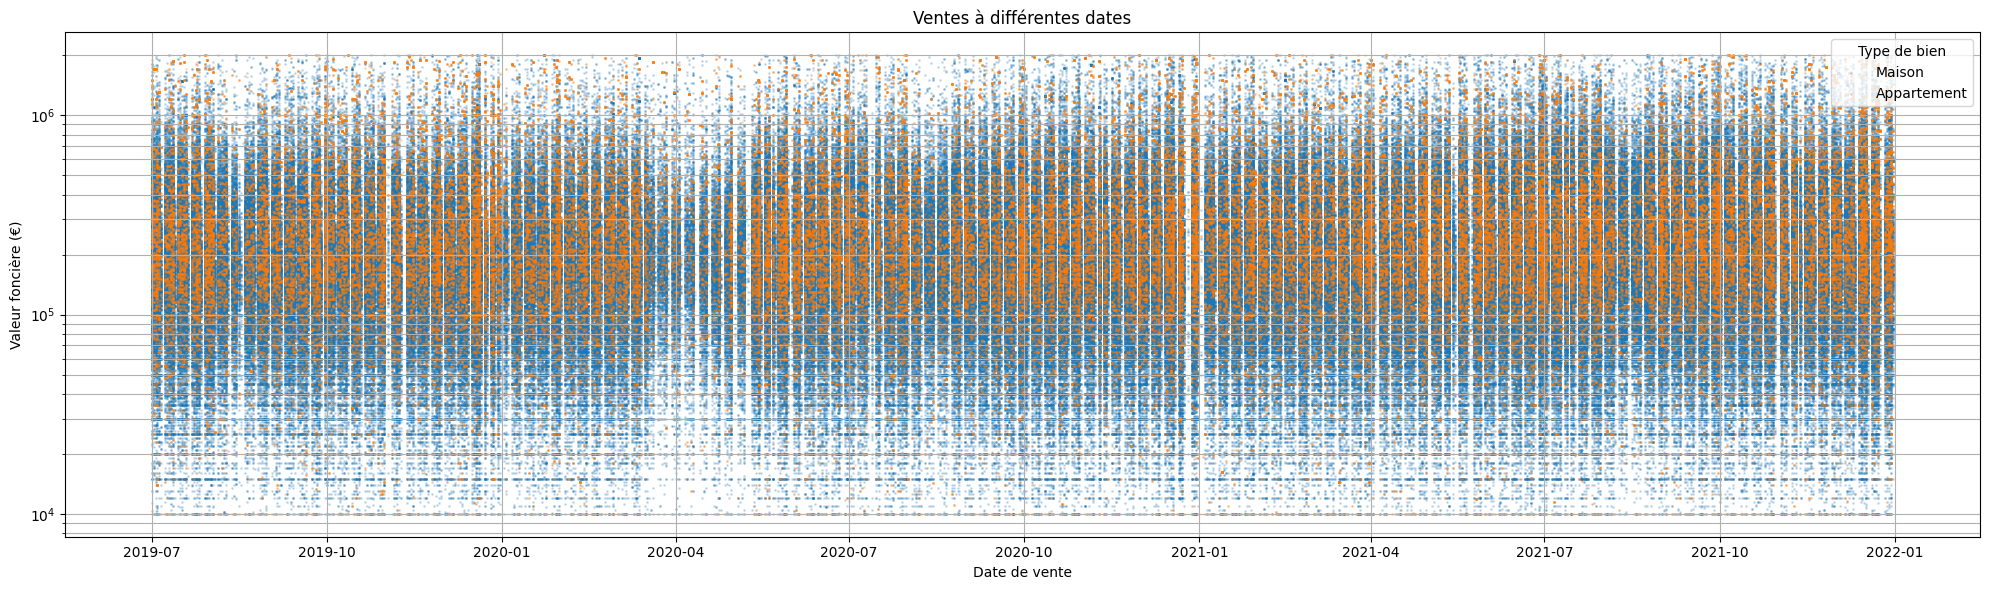

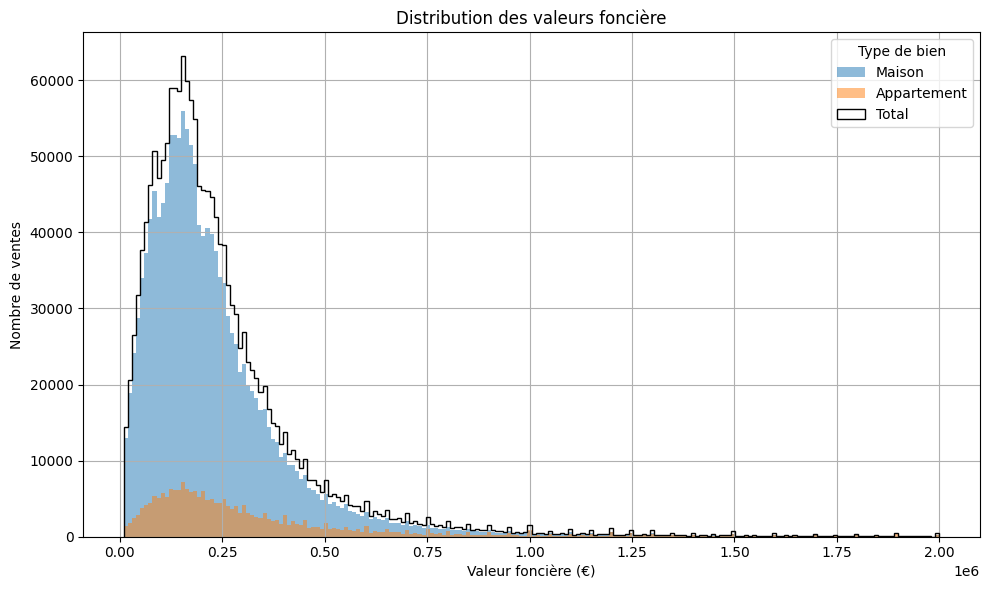

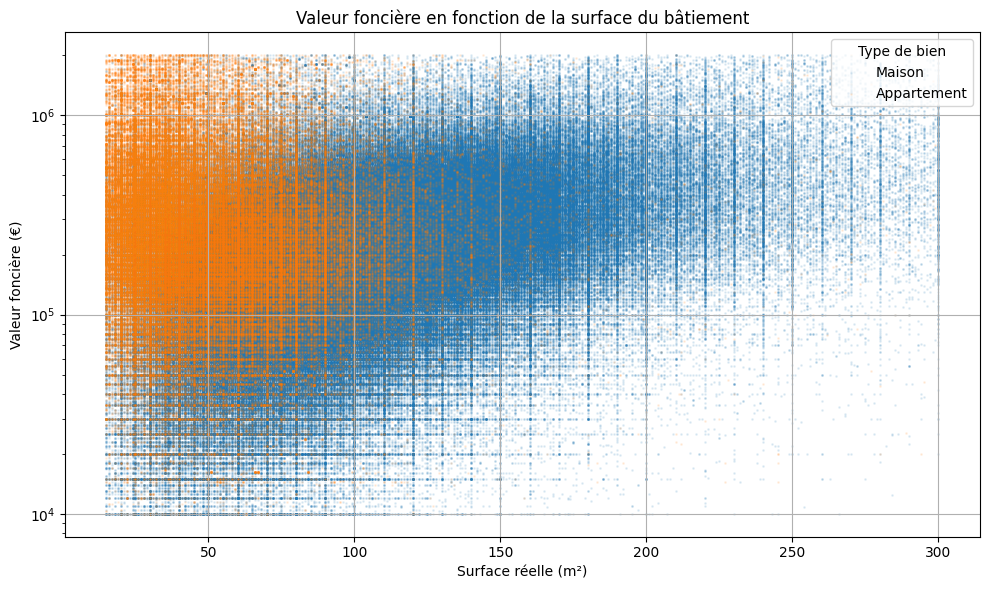

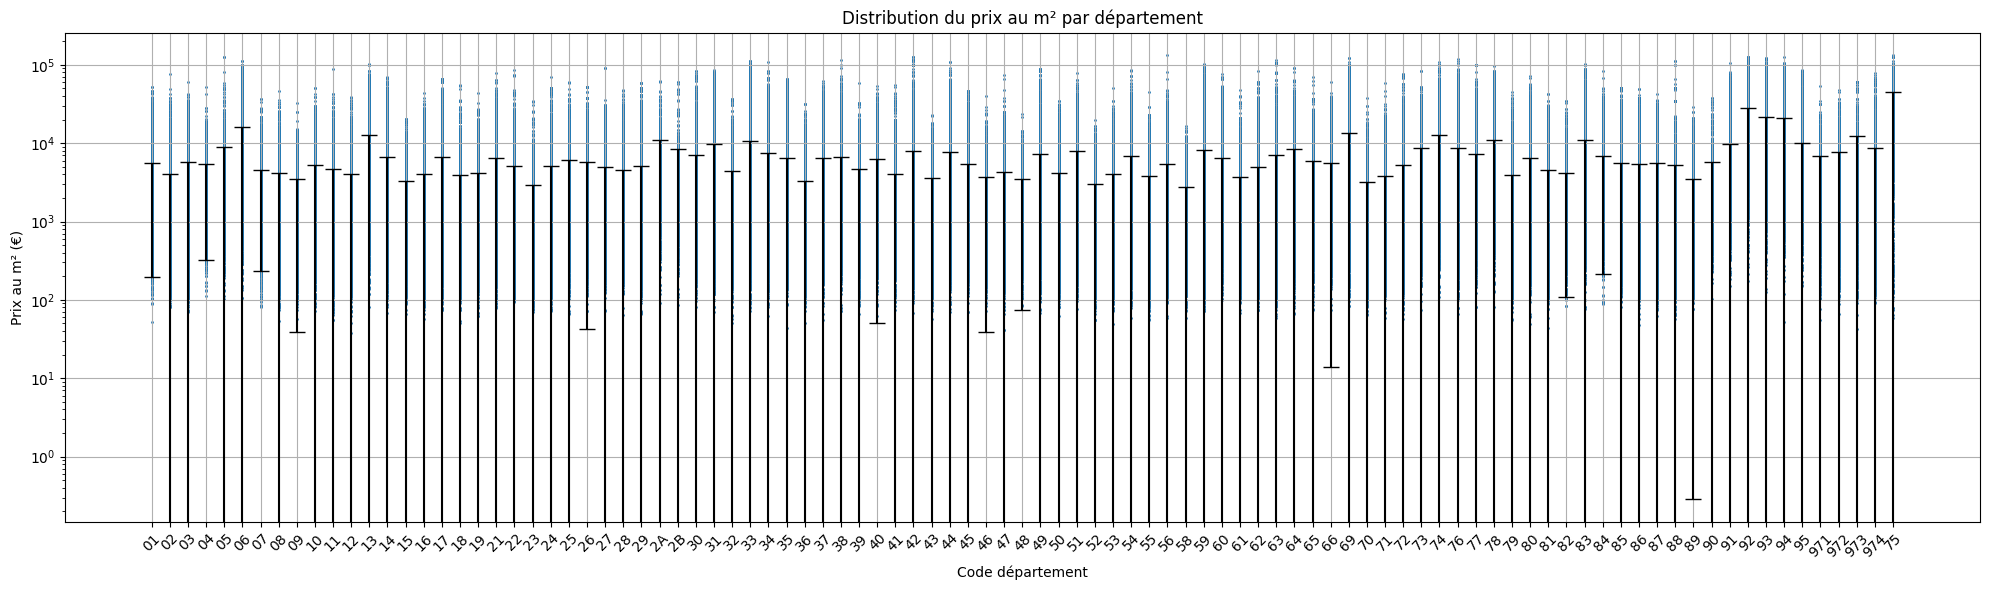

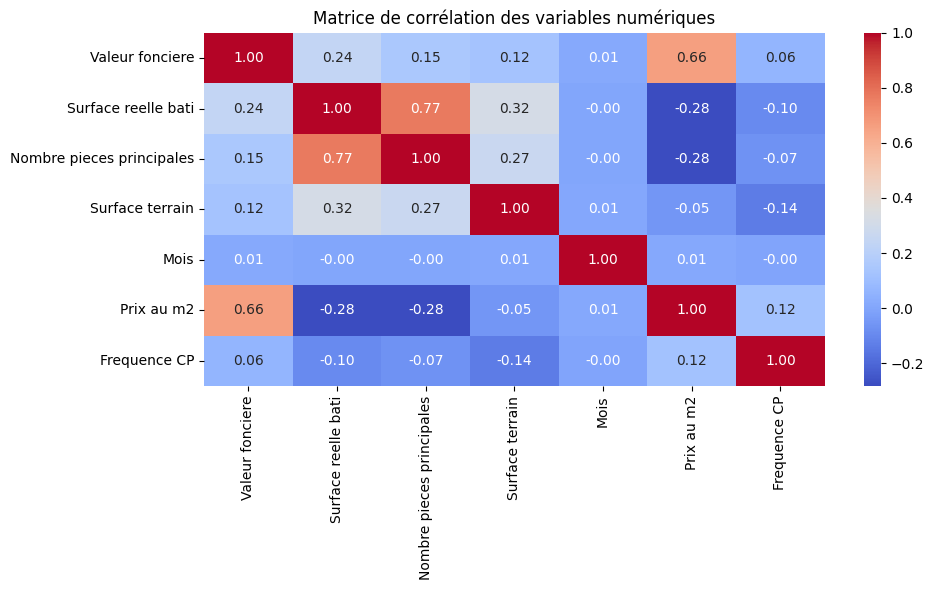

In [6]:
visualize_dataset(data, min_price= 10_000, max_price= 2_000_000)

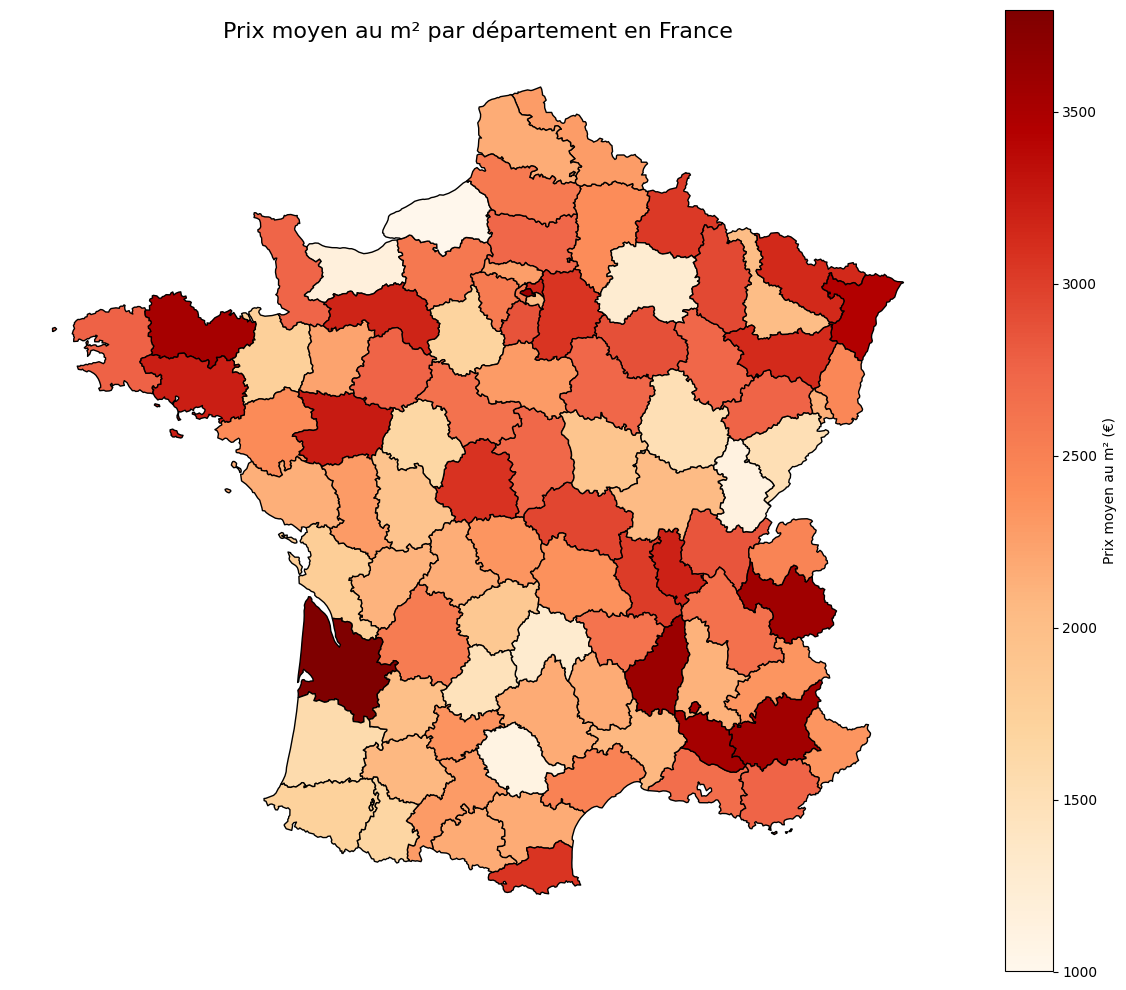

In [7]:
import geopandas as gpd

# Simuler les données de prix moyen au m² par département
np.random.seed(42)
departement_codes = [f"{i:02}" for i in range(1, 96) if i not in [20]]  # exclure 20 pour Corse
prix_moyen = np.random.normal(2500, 700, len(departement_codes)).clip(1000, 5000)
prix_par_dept = pd.DataFrame({
    "code_dept": departement_codes,
    "prix_m2_moyen": prix_moyen
})



# Lire un vrai fond de carte des départements français (utilisation d'une source alternative)
# Ici on charge un fichier GeoJSON connu via GeoPandas si disponible
url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
try:
    gdf_dept = gpd.read_file(url)
    # Harmoniser le format de code
    gdf_dept["code"] = gdf_dept["code"]
    # Merge avec les données de prix
    gdf_merged = gdf_dept.merge(prix_par_dept, left_on="code", right_on="code_dept", how="left")

    # Tracer la carte
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    gdf_merged.plot(
        column="prix_m2_moyen",
        ax=ax,
        legend=True,
        cmap="OrRd",
        legend_kwds={"label": "Prix moyen au m² (€)"},
        edgecolor="black"
    )
    ax.set_title("Prix moyen au m² par département en France", fontsize=16)
    ax.axis("off")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Impossible de charger la carte des départements :", e)


# PCA et Clustering

In [8]:
def process_features(X):
    '''
    Normalise et classifie X.

    Paramètres:
        X (Dataframe): DataFrame contenant les features.

    Retour:
        La DataFrame d'entrée avec ses valeurs processées.
    '''

    categorical_features = ["Code departement", "Type local"]
    numeric_features = ["Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Mois", "Frequence CP"]
    preprocessor = ColumnTransformer(transformers= [(
        'num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown= 'ignore'), categorical_features)
        ])
    X_processed = preprocessor.fit_transform(X)

    return X_processed

def do_pca(X, n_components= 10):
    '''
    Reduction dimensionnelle par PCA de l'entrée.

    Paramètres:
        X (DataFrame): données d'entrée.
        n_components (int): nombre de composantes principales à conserver.

    Retour:
        Données transformées.
    '''

    X_processed = process_features(X)
    pca = PCA(n_components= n_components)
    X_pca = pca.fit_transform(X_processed)

    return X_pca

def plot_explained_variance(X, n_components= 10):
    '''
    Affiche la variance expliquée cumulée pour une PCA de n_components sur les données d'entrée.

    Paramètres:
        X (DataFrame): données d'entrée.
        n_components (int): nombre de composantes principales à conserver.

    Retour:
        None
    '''

    X_processed = process_features(X)
    pca = PCA(n_components= n_components)
    pca.fit(X_processed)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    n = np.arange(1, len(cumulative_variance) + 1)

    plt.figure(figsize= (10, 4))
    plt.plot(n, cumulative_variance, marker= "o", color= "r", ls= "--")
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Variance expliquée cumulée")
    plt.title("Variance expliquée cumulée par PCA")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

In [9]:
dataset, features, target = parse_dataset(data, min_price= 10_000, max_price= 1_000_000)
X, y = dataset[features], dataset[target]
N = 100_000
X_sampled, y_sampled = X.sample(n= N, random_state= 42), y.sample(n= N, random_state= 42) #* Sous ensemble pour faire des test, même random_state pour même indices
X_processed = process_features(X)


k = 6
kmeans = KMeans(n_clusters= k)
cluster_labels = kmeans.fit_predict(X_processed)

print("Inertie :", kmeans.inertia_)
# print("Silhouette score :", silhouette_score(X_processed, cluster_labels))

Inertie : 5605256.945368561


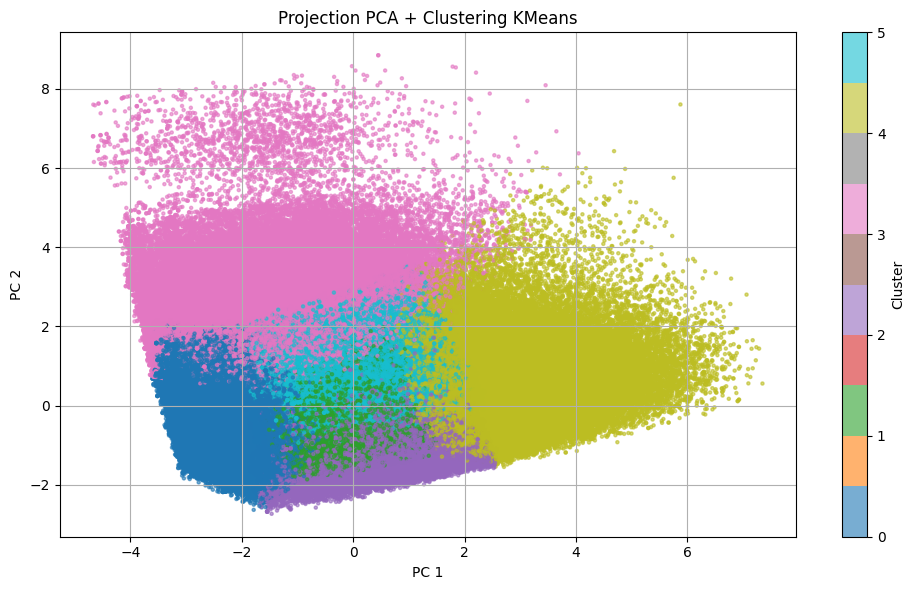

In [10]:
pca = PCA(n_components= 2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="tab10", s=5, alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title("Projection PCA + Clustering KMeans")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
df_clusters = X.copy()
df_clusters["cluster"] = cluster_labels
df_clusters["target"] = y_sampled  # ou y.to_numpy() si Series

# Moyenne des features et de la target par cluster
summary = df_clusters.groupby("cluster").agg({
    "Type local": lambda x: x.mode()[0],  # type dominant
    "Code departement": lambda x: x.mode()[0],
    "Surface terrain": ["mean", "std"],
    "Surface reelle bati": ["mean", "std"],
    "Nombre pieces principales": ["mean", "std"],
    "Frequence CP": "mean",
    "Mois": "mean",
    "target": ["mean", "std", "max"]
}).round(2)

summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
display(summary)

Type local_<lambda> Code departement_<lambda>  Surface terrain_mean  \
cluster                                                                       
0                    Maison                        59                242.52   
1                    Maison                        59                308.73   
2                    Maison                        33                775.53   
3                    Maison                        59                275.87   
4                    Maison                        59                584.64   
5                    Maison                        59                435.86   

         Surface terrain_std  Surface reelle bati_mean  \
cluster                                                  
0                     185.26                     47.83   
1                     149.79                     94.05   
2                     141.33                     94.55   
3                     196.13                     74.43   
4                     224.45                    162.56   
5                     224.34                     93.16   

         Surface reelle bati_std  Nombre pieces principales_mean  \
cluster                                                            
0                          17.05                            2.07   
1                          21.38                            4.17   
2                          24.44                            3.96   
3                          33.07                            3.42   
4                          35.95                            6.11   
5                          24.42                            4.05   

         Nombre pieces principales_std  Frequence CP_mean  Mois_mean  \
cluster                                                                
0                                 0.77             905.99       7.63   
1                                 0.83             790.82       9.56   
2                                 0.97             788.61       8.83   
3                                 1.40            3665.19       7.54   
4                                 1.16             870.92       7.54   
5                                 0.96             817.61       3.00   

         target_mean  target_std  target_max  
cluster                                       
0          193119.41   175484.35   1000000.0  
1          211551.80   143575.12   1000000.0  
2          223800.52   143374.86   1000000.0  
3          238138.49   167025.19   1000000.0  
4          335318.97   194951.81   1000000.0  
5          209537.21   143099.72   1000000.0

# Random Forest

### Truncated dataset

In [12]:
dataset, features, target = parse_dataset(data, min_price= 10_000, max_price= 1_000_000)
X, y = dataset[features], dataset[target]

In [13]:
N = 100_000
X_sampled, y_sampled = X.sample(n= N, random_state= 42), y.sample(n= N, random_state= 42) #* Sous ensemble pour faire des test, même randome_state pour même indices
X_processed = process_features(X_sampled)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_sampled, test_size= .2)
y_train = np.log1p(y_train)

In [14]:
# r2_max = 0
# n_max, m_max = 0, 0
# for n in tqdm(range(10, 105, 5)):
#     for m in range(15, 105, 5):
#         model = RandomForestRegressor(n_estimators= n, max_depth= m, n_jobs= -1, random_state= 42)
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         y_pred = np.expm1(y_pred)
#         r2 = r2_score(y_test, y_pred)
#         if r2 > r2_max:
#             r2_max = r2
#             n_max, m_max = n, m

# print(f"n= {n_max}, m= {m_max}, R²= {r2_max:.2f}")

In [15]:
model = RandomForestRegressor(n_estimators= 35, max_depth= 55, n_jobs= -1, random_state= 42)

In [16]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=55, n_estimators=35, n_jobs=-1, random_state=42)

MAE : 82450.58 €
RMSE : 125833.35 €
R² : 0.4222


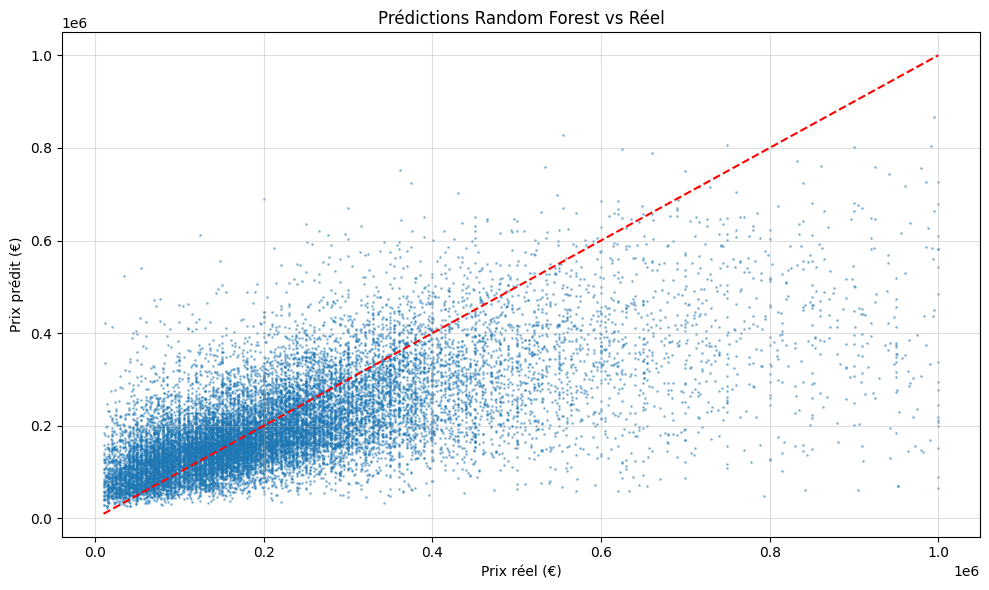

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"R² : {r2:.4f}")

plt.figure(figsize= (10, 6))
plt.scatter(y_test, y_pred, s= 1, alpha= .4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Prix réel (€)")
plt.ylabel("Prix prédit (€)")
plt.title("Prédictions Random Forest vs Réel")
plt.grid(True, alpha= .4)
plt.loglog()
plt.tight_layout()
plt.show()

### Truncated with PCA

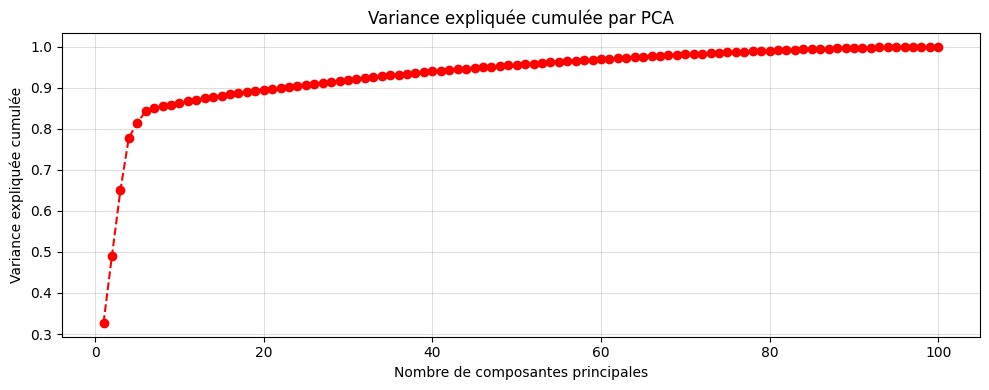

In [18]:
plot_explained_variance(X_sampled, 100)

In [19]:
X_pca = do_pca(X_sampled, n_components= 10)

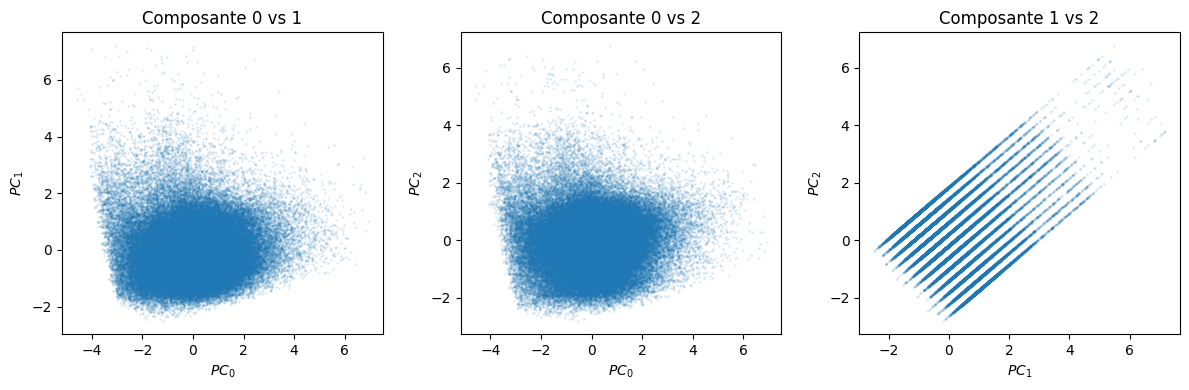

In [20]:
plt.figure(figsize= (12, 4))

plt.subplot(131)
plt.scatter(X_pca[:, 0], X_pca[:, 1], s= 1, alpha= .1)
plt.xlabel(r"$PC_0$")
plt.ylabel(r"$PC_1$")
plt.title("Composante 0 vs 1")

plt.subplot(132)
plt.scatter(X_pca[:, 0], X_pca[:, 2], s= 1, alpha= .1)
plt.xlabel(r"$PC_0$")
plt.ylabel(r"$PC_2$")
plt.title("Composante 0 vs 2")

plt.subplot(133)
plt.scatter(X_pca[:, 1], X_pca[:, 2], s= 1, alpha= .1)
plt.xlabel(r"$PC_1$")
plt.ylabel(r"$PC_2$")
plt.title("Composante 1 vs 2")

plt.tight_layout()
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_sampled, test_size= .2, random_state= 42)
y_train = np.log1p(y_train)

In [22]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=55, n_estimators=35, n_jobs=-1, random_state=42)

MAE : 97633.43 €
RMSE : 148091.13 €
R² : 0.2026


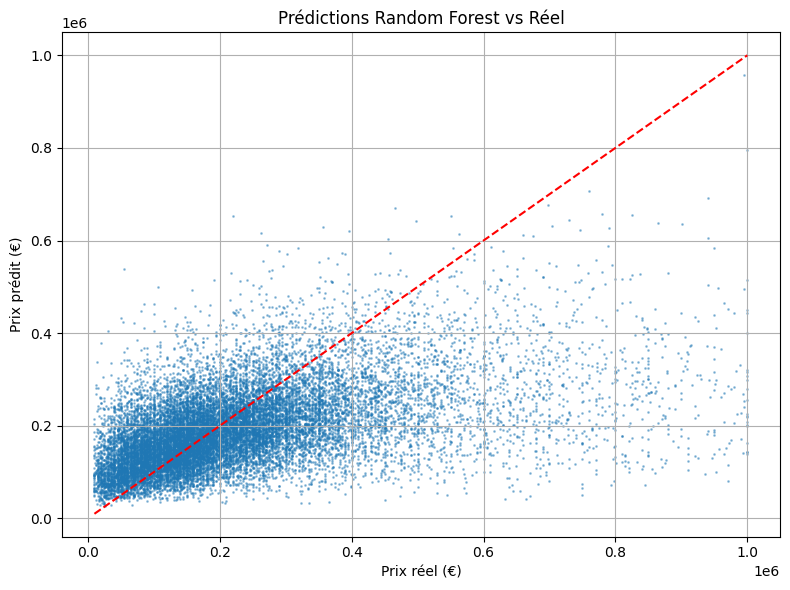

In [23]:
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"R² : {r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha= .4, s= 1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Prix réel (€)")
plt.ylabel("Prix prédit (€)")
plt.title("Prédictions Random Forest vs Réel")
plt.grid(True)
plt.tight_layout()
plt.show()

### Full dataset

In [26]:
X_train, X_test, y_train, y_test = train_test_split(process_features(X), y, test_size= .2, random_state= 42)
y_train = np.log1p(y_train)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=55, n_estimators=35, n_jobs=-1, random_state=42)

MAE : 65970.61 €
RMSE : 101515.11 €
R² : 0.6177


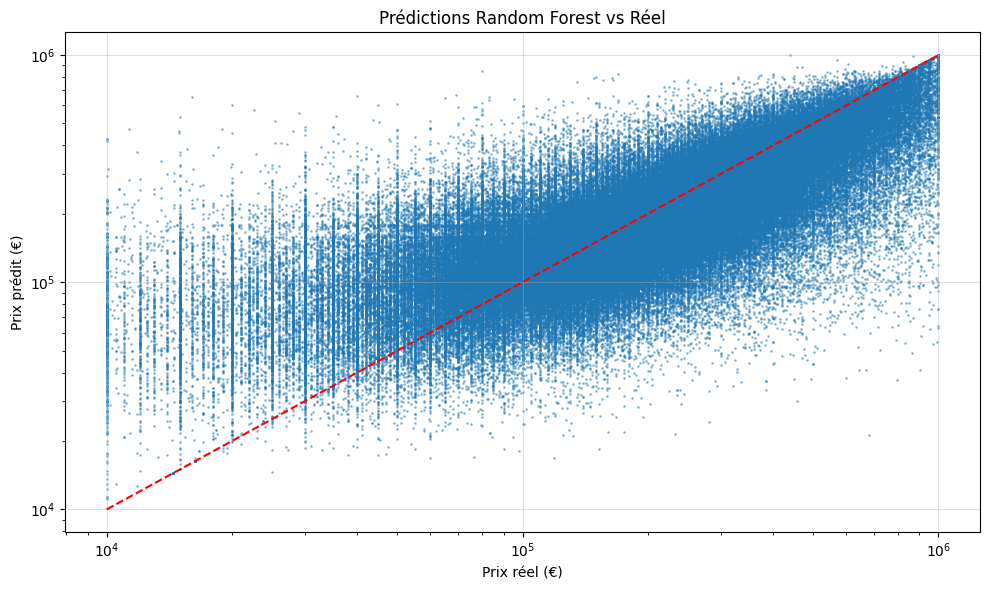

: 

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"R² : {r2:.4f}")

plt.figure(figsize= (10, 6))
plt.scatter(y_test, y_pred, alpha= .4, s= 1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Prix réel (€)")
plt.ylabel("Prix prédit (€)")
plt.title("Prédictions Random Forest vs Réel")
plt.grid(True, alpha= .4)
plt.loglog()
plt.tight_layout()
plt.show()

### Full with PCA

In [ ]:
# X_pca = do_pca(X, n_components= 10)
# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size= .2, random_state= 42)
# model.fit(X_train, y_train)

In [ ]:
# y_pred = model.predict(X_test)

# mae = mean_absolute_error(y_test, y_pred)
# rmse = root_mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"MAE : {mae:.2f} €")
# print(f"RMSE : {rmse:.2f} €")
# print(f"R² : {r2:.4f}")

# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_pred, alpha= .4, s= 1)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.xlabel("Prix réel (€)")
# plt.ylabel("Prix prédit (€)")
# plt.title("Prédictions Random Forest vs Réel")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# MLP

In [ ]:
def create_gpu_dataset(X, y, batch_size= 2048):
    '''
    Create a tf.data.dataset for GPU usage.

    Parametres:
    Retour:
    '''
    
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size= tf.data.AUTOTUNE)

    return dataset

def build_mlp_model(input_shape= 0, n_layers= 1, lrate= 1e-3):

    model = Sequential()
    model.add(Input(shape = (input_shape,)))
    model.add(Dense(2 ** 9, activation= 'relu'))

    for n in range(1, n_layers):
        model.add(Dense(2 ** (9 - n), activation= 'relu'))
        model.add(Dropout(.3))

    model.add(Dense(1))

    model.summary()
    model.compile(optimizer= Adam(learning_rate= lrate), loss= 'mse', metrics= ['mae'])
    return model

In [ ]:
# dataset, features, target = parse_dataset(data, min_price= 10_000, max_price= 1_000_000)
# X, y = dataset[features], dataset[target]

# N = 100_000
# X_sampled, y_sampled = X.sample(n= N, random_state= 42), y.sample(n= N, random_state= 42)
# X_processed = process_features(X_sampled)

# # X_dense = X_processed.toarray().astype("float32")
# # y_dense = y_sampled.astype("float32")

# X_train, X_test, y_train, y_test = train_test_split(X_processed, y_sampled, test_size= .2)
# y_train = np.log1p(y_train)

# # training_dataset = create_gpu_dataset(X_train, y_train)
# # testing_dataset = create_gpu_dataset(X_test, y_test)

In [ ]:
# # model = Sequential([
# #     Dense(256, activation= 'relu', input_shape=(X_train.shape[1],)),
# #     Dropout(.3),
# #     Dense(128, activation= 'relu'),
# #     Dropout(.3),
# #     Dense(64, activation= 'relu'),
# #     Dropout(.3),
# #     Dense(32, activation= 'relu'),
# #     Dense(1)
# # ])

# # model.summary()
# # model.compile(optimizer= Adam(learning_rate= 1e-3), loss= 'mse', metrics= ['mae'])

# model = build_mlp_model(X_train.shape[1], n_layers= 3)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 512)            │        53,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,113 (852.00 KB)

 Trainable params: 218,113 (852.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(patience= 10, restore_best_weights= True)

# batch_size = X_train.shape[0] * X_train.shape[1]
# history = model.fit(
#     X_train, y_train,
#     # training_dataset,
#     batch_size= 4096,
#     epochs= 300,
#     validation_split= .2,
#     # validation_data= testing_dataset,
#     callbacks= [early_stop],
#     verbose= 1)
# ev = model.evaluate(X_test, y_test)
# print(ev)

Epoch 1/1000


2025-04-21 17:22:12.768695: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_168', 8 bytes spill stores, 8 bytes spill loads

2025-04-21 17:22:13.106343: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_168', 484 bytes spill stores, 484 bytes spill loads



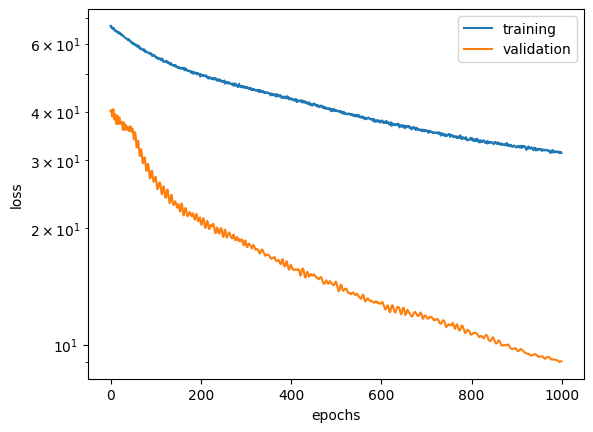

In [ ]:
# plt.figure()
# plt.plot(history.history['loss'], label= 'training')
# plt.plot(history.history['val_loss'], label= 'validation')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.yscale('log')
# plt.legend()
# plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MAE : 218023.43 €
RMSE : 271156.02 €
R² : -1.7798


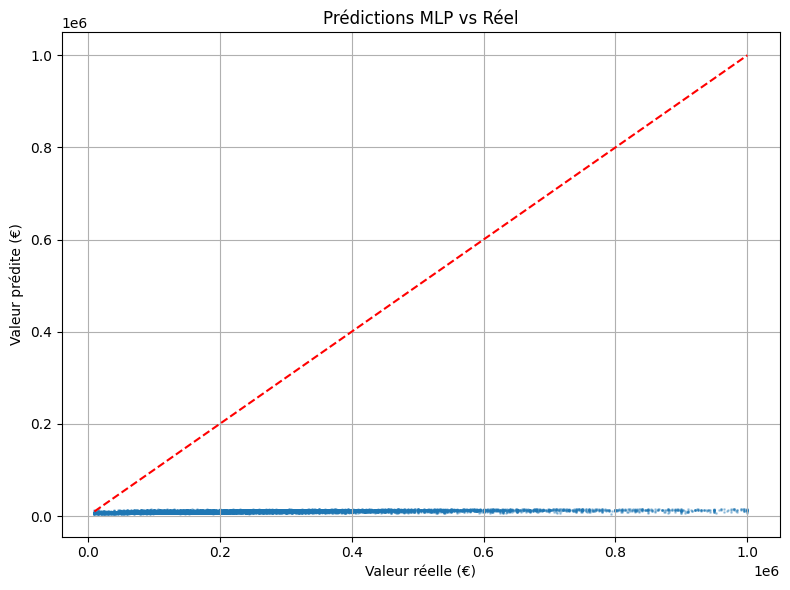

In [ ]:
# y_pred = model.predict(X_test).flatten()
# y_pred = np.expm1(y_pred)

# mae = mean_absolute_error(y_test, y_pred)
# rmse = root_mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"MAE : {mae:.2f} €")
# print(f"RMSE : {rmse:.2f} €")
# print(f"R² : {r2:.4f}")

# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_pred, alpha= .3, s= 1)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.xlabel("Valeur réelle (€)")
# plt.ylabel("Valeur prédite (€)")
# plt.title("Prédictions MLP vs Réel")
# plt.grid(True)
# plt.tight_layout()
# plt.show()